<a href="https://colab.research.google.com/github/stefelmax/deseases-NLP-RNN-/blob/main/RNN_%D0%9E%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B1%D0%BE%D0%BB%D0%B5%D0%B7%D0%BD%D0%B5%D0%B9_(NLP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Распознование заболеваний

##Подготовка дынных

###Импорт библиотек

In [ ]:
from google.colab import files # Для работы с файлами 
import numpy as np # Для работы с данными 
import pandas as pd # Для работы с таблицами
import matplotlib.pyplot as plt # Для вывода графиков
import os # Для работы с файлами
import gc
import re
%matplotlib inline

from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.models import Sequential # Полносвязная модель
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Conv1D, MaxPool1D # Слои для сети
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder # Метод кодирования тестовых лейблов
from sklearn.model_selection import train_test_split # Для разделения выборки на тестовую и обучающую
from google.colab import drive # Для работы с Google Drive
import time # Импортируем библиотеку time
import seaborn as sns # Импортируем библиотеку seaborn
sns.set_style('darkgrid') # Устанавливаем стиль графиков

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Загрузка данных

In [ ]:
!rm -R /content/disease #Проверяем, есть ли папка. Если да, удаляем её.

! unzip -q '/content/drive/MyDrive/neuro/data/disease.zip' -d '/content/disease' 
#Указываем путь к архиву на Google Drive, и разархивируем его по указанному пути.
# - q означает, что не будет отображаться статус распаковки.
# Можно зайти в файловый менеджер Гугла, найти файл и скопировать к нему путь.

In [ ]:
titles = os.listdir('/content/disease/Болезни')
dir = '/content/disease/Болезни/'

def get_data(dir, titles):
  text = [] 
  desease = []

  for t in titles:
    desease.append(t[:-4]) #добавляем в список название болезни без .txt

    with open(dir + t, 'r') as f:
      text.append(f.read().strip())

  return (text, desease)


trainText, yTrain = get_data(dir, titles)
nClasses = yTrain

###Токенайзер

In [ ]:
maxWordsCount = 500

tokenizer = Tokenizer(
    num_words=maxWordsCount,
    filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
    lower=True,
    split=' ',
    oov_token='unknown',
    char_level=False)

tokenizer.fit_on_texts(trainText) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра
trainWordIndexes = tokenizer.texts_to_sequences(trainText) #переводим слова из нашей выборки в индексы частотности (1-неизвестное, 2 самое популярное, и тд)

In [ ]:
print(trainWordIndexes[1])

[4, 71, 1, 2, 63, 3, 1, 12, 28, 6, 430, 4, 1, 90, 188, 6, 1, 31, 90, 43, 1, 4, 2, 45, 13, 431, 14, 20, 23, 72, 19, 7, 3, 5, 12, 28, 4, 12, 28, 3, 2, 1, 83, 1, 1, 22, 432, 274, 6, 1, 107, 143, 223, 7, 86, 336, 46, 4, 2, 11, 4, 159, 2, 1, 9, 73, 189, 1, 90, 433, 39, 434, 275, 276, 159, 2, 37, 38, 9, 337, 1, 82, 20, 7, 5, 49, 17, 1, 4, 2, 37, 38, 9, 338, 88, 5, 7, 23, 17, 23, 91, 16, 127, 161, 30, 102, 34, 224, 277, 222, 3, 1, 64, 65, 190, 162, 278, 141, 1, 91, 5, 7, 20, 3, 14, 1, 191, 6, 225, 8, 1, 2, 45, 13, 339, 163, 279, 6, 435, 12, 28, 84, 20, 74, 2, 280, 3, 1, 1, 14, 86, 5, 14, 112, 86, 6, 192, 193, 66, 2, 45, 13, 12, 58, 24, 43, 1, 1, 46, 23, 17, 10, 1, 162, 1, 146, 7, 1, 1, 340, 41, 1, 10, 1, 1, 129, 1, 4, 2, 45, 13, 5, 7, 321, 226, 214, 9, 48, 1, 14, 49, 17, 6, 42, 91, 5, 436, 6, 281, 1, 7, 4, 6, 164, 2, 63, 1, 107, 186, 341, 12, 28, 1, 12, 58, 24, 6, 430, 437, 5, 7, 4, 2, 37, 126, 9, 280, 3, 342, 8, 20, 5, 7, 431, 14, 77, 20, 14, 86, 5, 7, 30, 1, 282, 1, 1, 227, 33, 438, 4, 5, 6

###Сэмплирование

In [ ]:
def sampling(xTrain, yTrain, xLen, xFrame):
  xSample = []
  ySample = []
  index = 0

  for i, xT in enumerate(xTrain):
    index = 0
    while ((index + xLen) < len(xT)):
      xSample.append(xT[index:index+xLen])
      ySample.append((utils.to_categorical(i, len(xTrain))))
      index += xFrame

  xSample = np.array(xSample)
  ySample = np.array(ySample)

  return (xSample, ySample)

xLen = 15
xFrame = 1

xTrain, yTrain =  sampling(trainWordIndexes, yTrain, xLen, xFrame)   
x_train, x_test, y_train, y_test = train_test_split(xTrain, yTrain, test_size=0.2)
x_test, x_check, y_test, y_check = train_test_split(x_test, y_test, test_size=0.5)

### Распознавание тестовой выборки

In [ ]:
def recognizeDisease(model):
  results = model.predict(x_check)

  arr = {}
  evals = {}
  res = []

  for i in range(len(results)):
    res.append(np.argmax(y_check[i]))
    if np.argmax(results[i]) == np.argmax(y_check[i]):
      arr.setdefault(np.argmax(y_check[i]), 0)    
      arr[np.argmax(y_check[i])] += 1

  for k, v in arr.items():
    evals[nClasses[k]] = round(arr[k] / res.count(k) * 100, 2)
    print(nClasses[k], ' '*(10 - len(nClasses[k])), 'распознан с точностью', evals[nClasses[k]], '%')

##Эксперименты

### EMBEDDING + DENSE (SIMPLE)

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_47 (Embedding)    (None, 15, 20)            10000     
                                                                 
 flatten_47 (Flatten)        (None, 300)               0         
                                                                 
 dense_95 (Dense)            (None, 50)                15050     
                                                                 
 dropout_48 (Dropout)        (None, 50)                0         
                                                                 
 batch_normalization_48 (Bat  (None, 50)               200       
 chNormalization)                                                
                                                                 
 dense_96 (Dense)            (None, 10)                510       
                                                     

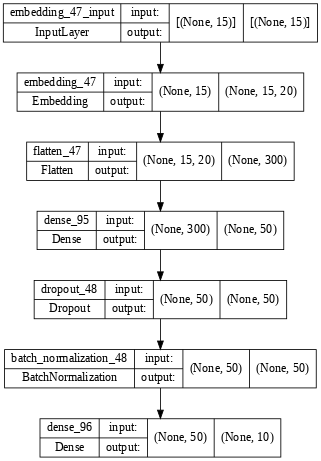

In [ ]:
modelED = Sequential()

modelED.add(Embedding(maxWordsCount, 20, input_length=xLen))
modelED.add(Flatten())
modelED.add(Dense(50, activation='relu'))
modelED.add(Dropout(0.2))
modelED.add(BatchNormalization())
modelED.add(Dense(10, activation='softmax'))

modelED.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

modelED.summary()
plot_model(modelED, dpi=60, show_shapes=True)

In [ ]:
history_ED = modelED.fit(x_train, y_train,
                              epochs=15,
                              batch_size=28,
                              validation_data=(x_test, y_test))

Epoch 1/15
230/230 [==============================] - 2s 4ms/step - loss: 2.1231 - accuracy: 0.2499 - val_loss: 2.0878 - val_accuracy: 0.2894
Epoch 2/15
230/230 [==============================] - 1s 3ms/step - loss: 1.0431 - accuracy: 0.6714 - val_loss: 0.9371 - val_accuracy: 0.8273
Epoch 3/15
230/230 [==============================] - 1s 3ms/step - loss: 0.4369 - accuracy: 0.8737 - val_loss: 0.3045 - val_accuracy: 0.9242
Epoch 4/15
230/230 [==============================] - 1s 3ms/step - loss: 0.2247 - accuracy: 0.9422 - val_loss: 0.1796 - val_accuracy: 0.9528
Epoch 5/15
230/230 [==============================] - 1s 3ms/step - loss: 0.1385 - accuracy: 0.9616 - val_loss: 0.1355 - val_accuracy: 0.9602
Epoch 6/15
230/230 [==============================] - 1s 3ms/step - loss: 0.0959 - accuracy: 0.9759 - val_loss: 0.1089 - val_accuracy: 0.9702
Epoch 7/15
230/230 [==============================] - 1s 3ms/step - loss: 0.0725 - accuracy: 0.9814 - val_loss: 0.0881 - val_accuracy: 0.9689
Epoch 

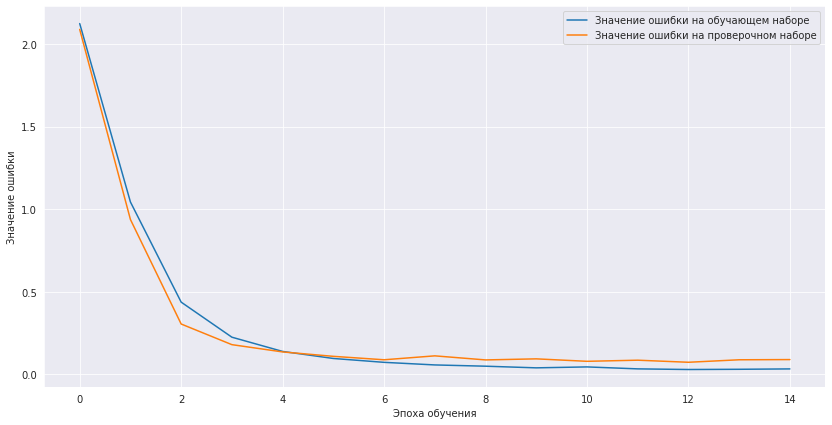

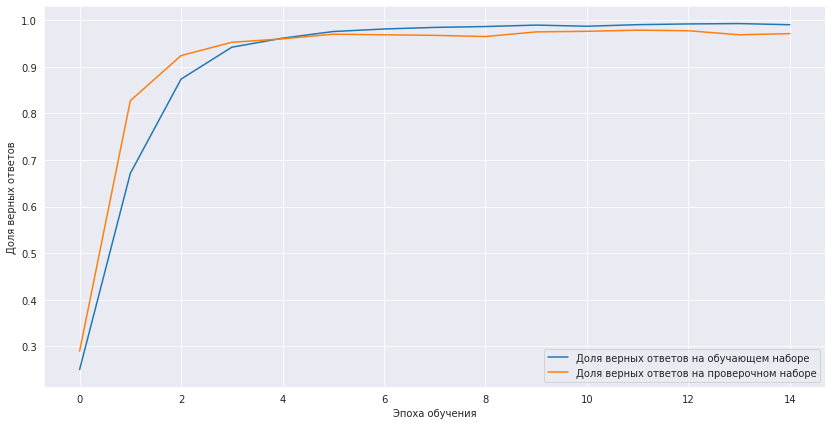

In [ ]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history_ED.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history_ED.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history_ED.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_ED.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
recognizeDisease(modelED)

Колит       распознан с точностью 97.32 %
Эзофагит    распознан с точностью 100.0 %
Гепатит     распознан с точностью 97.18 %
Гастрит     распознан с точностью 95.4 %
Энтерит     распознан с точностью 98.88 %
Аппендицит  распознан с точностью 98.55 %
Дуоденит    распознан с точностью 97.56 %
Язва        распознан с точностью 93.18 %
Панкреатит  распознан с точностью 99.37 %
Холицестит  распознан с точностью 93.24 %
